这个文件用来训练Segmentation模型

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from utils import *

In [2]:
# 加载预训练的Faster R-CNN模型
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# 获取分类器的输入特征数
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 替换预训练的头部为一个新的，只有两个类别（背景和单词）
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
class ModifiedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.trans = transforms.Normalize(mean=(0.5), std=(0.5))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img -= img.mean()
        img /= img.std()
        # img = self.trans(img)

        # 将 (x, y, w, h) 格式的边界框转换为 (x1, y1, x2, y2) 格式
        label[:, 2] = label[:, 0] + label[:, 2]
        label[:, 3] = label[:, 1] + label[:, 3]

        # 仅保留包含单词的边界框
        indices = label.sum(dim=-1) > 0
        label = label[indices]

        # 制造classifier的标签
        temp = torch.ones(len(label), dtype=torch.long)
        label = {'boxes': label, 'labels': temp}
        
        return img, label


from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # 使用默认的 collate 处理图片（因为图片大小相同）
    images = default_collate(images)
    
    # 不尝试合并 targets，因为它们包含不同数量的边界框
    # 直接作为列表返回
    return images, targets

In [4]:
dataset = ModifiedDataset(SegDataset('IAM', 'train'))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [5]:
def get_model_name(epoch):
    return f"fasterrcnn_{epoch}.pth"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# 训练模式
model.train()

num_epochs = 100

for epoch in range(num_epochs):
    for step, (images, targets) in enumerate(dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # print("images:\n", images)
        # print("targets:\n", targets)

        # 计算损失
        loss_dict = model(images, targets)
        # print("loss_dict:\n", loss_dict)
        losses = sum(loss for loss in loss_dict.values())

        # 反向传播
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Epoch {epoch} step {step} loss: {losses.item()}")
    print(f"Epoch {epoch} loss: {losses.item()}")
    model_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/Faster_R_CNN/'
    model_name = model_path + get_model_name(epoch)
    torch.save(model.state_dict(), model_name)

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0 step 0 loss: 3.180299758911133
Epoch 0 step 1 loss: 4.038980484008789
Epoch 0 step 2 loss: 3.400888204574585
Epoch 0 step 3 loss: 2.805983066558838
Epoch 0 step 4 loss: 3.053529977798462
Epoch 0 step 5 loss: 2.9373779296875
Epoch 0 step 6 loss: 2.796520948410034
Epoch 0 step 7 loss: 2.8418173789978027
Epoch 0 step 8 loss: 2.8542990684509277
Epoch 0 step 9 loss: 2.8125131130218506
Epoch 0 step 10 loss: 2.76536226272583
Epoch 0 step 11 loss: 2.725536584854126
Epoch 0 step 12 loss: 2.750455379486084
Epoch 0 step 13 loss: 2.7165558338165283
Epoch 0 step 14 loss: 2.678511619567871
Epoch 0 step 15 loss: 2.6542582511901855
Epoch 0 step 16 loss: 2.5888171195983887
Epoch 0 step 17 loss: 2.6470413208007812
Epoch 0 step 18 loss: 2.6519579887390137
Epoch 0 step 19 loss: 2.6029562950134277
Epoch 0 step 20 loss: 2.5891218185424805
Epoch 0 step 21 loss: 2.587179183959961
Epoch 0 step 22 loss: 2.5505104064941406
Epoch 0 step 23 loss: 2.5062966346740723
Epoch 0 step 24 loss: 2.567988634109497
E

出图

Epoch 0 loss: 2.3430882661770553
Epoch 1 loss: 1.406146147312262
Epoch 2 loss: 0.9555601278940836
Epoch 3 loss: 0.6870545928294842
Epoch 4 loss: 0.5317501242344196
Epoch 5 loss: 0.452578862508138
Epoch 6 loss: 0.4057989701246604
Epoch 7 loss: 0.37325896819432575
Epoch 8 loss: 0.36268837329668874
Epoch 9 loss: 0.3585699506295033
Epoch 10 loss: 0.363021303445865
Epoch 11 loss: 0.3797678259702829
Epoch 12 loss: 0.3872361435340001
Epoch 13 loss: 0.3661219760393485
Epoch 14 loss: 0.35631023538418305
Epoch 15 loss: 0.4260805241572551
Epoch 16 loss: 0.40225165623884934
Epoch 17 loss: 0.38193164345545644
Epoch 18 loss: 0.38375144050671506
Epoch 19 loss: 0.3820652785973671
Epoch 20 loss: 0.42931783428558934
Epoch 21 loss: 0.372503474736825
Epoch 22 loss: 0.3730482145761832
Epoch 23 loss: 0.33291935538634276
Epoch 24 loss: 0.3118127867197379
Epoch 25 loss: 0.35739472355598056
Epoch 26 loss: 0.3428008212493016
Epoch 27 loss: 0.316279404438459
Epoch 28 loss: 0.32012932804914623
Epoch 29 loss: 0.29

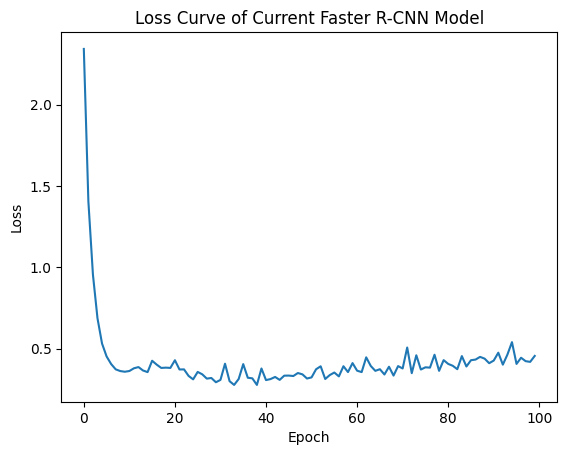

In [13]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from utils import *

def get_model_name(epoch):
    return f"fasterrcnn_{epoch}.pth"

def load_model(model, epoch):
    model_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/Faster_R_CNN/'
    model_name = model_path + get_model_name(epoch)
    model.load_state_dict(torch.load(model_name))
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_crv = []
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)
model.to(device)

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = default_collate(images)
    return images, targets

dataset = ModifiedDataset(SegDataset('IAM', 'train'))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

for epoch in range(100):
    model = load_model(model, epoch)
    # model.eval()
    total_loss = 0
    total_step = 0
    with torch.no_grad():
        for step, (images, targets) in enumerate(dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 计算损失
            loss_dict = model(images, targets)
            # print(loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            total_step += 1

            # print(f"Epoch {epoch} step {step} loss: {losses.item()}")
    losses = total_loss / total_step
    loss_crv.append(losses)
    print(f"Epoch {epoch} loss: {losses}")

plt.plot(np.arange(len(loss_crv)), loss_crv)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Current Faster R-CNN Model')
plt.show()

In [14]:
# save loss crv
import pickle
with open('train_crv.pkl', 'wb') as f:
    pickle.dump(loss_crv, f)

In [15]:
# validation crv

dataset = ModifiedDataset(SegDataset('IAM', 'val'))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_crv = []
for epoch in range(100):
    model = load_model(model, epoch)
    # model.eval()
    total_loss = 0
    total_step = 0
    with torch.no_grad():
        for step, (images, targets) in enumerate(dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 计算损失
            loss_dict = model(images, targets)
            # print(loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            total_step += 1

            # print(f"Epoch {epoch} step {step} loss: {losses.item()}")
    losses = total_loss / total_step
    val_crv.append(losses)
    print(f"Epoch {epoch} loss: {losses}")

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0 loss: 2.3937403678894045
Epoch 1 loss: 1.4132689952850341
Epoch 2 loss: 0.9501038670539856
Epoch 3 loss: 0.6789250016212464
Epoch 4 loss: 0.528100597858429
Epoch 5 loss: 0.4638660132884979
Epoch 6 loss: 0.4135788559913635
Epoch 7 loss: 0.3777868807315826
Epoch 8 loss: 0.36378070116043093
Epoch 9 loss: 0.3573130011558533
Epoch 10 loss: 0.3569773077964783
Epoch 11 loss: 0.38963437676429746
Epoch 12 loss: 0.390592485666275
Epoch 13 loss: 0.36112846732139586
Epoch 14 loss: 0.3532510221004486
Epoch 15 loss: 0.4232593238353729
Epoch 16 loss: 0.40438262224197385
Epoch 17 loss: 0.372318035364151
Epoch 18 loss: 0.3623042583465576
Epoch 19 loss: 0.3534569501876831
Epoch 20 loss: 0.4087063312530518
Epoch 21 loss: 0.33974774479866027
Epoch 22 loss: 0.3365471661090851
Epoch 23 loss: 0.3191616714000702
Epoch 24 loss: 0.29890450835227966
Epoch 25 loss: 0.3506736636161804
Epoch 26 loss: 0.3467234969139099
Epoch 27 loss: 0.317995685338974
Epoch 28 loss: 0.3178845465183258
Epoch 29 loss: 0.29660

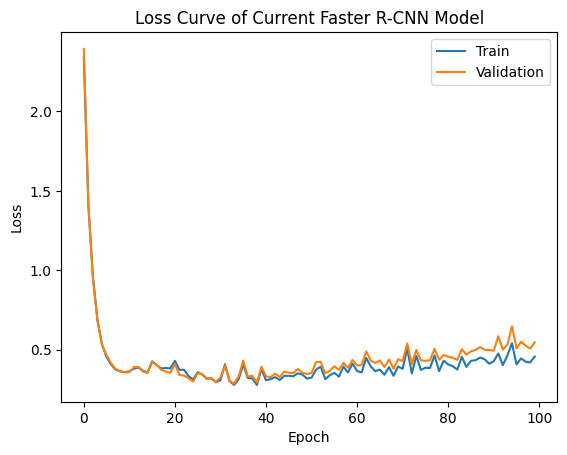

In [17]:
# plot both crv
plt.plot(np.arange(len(loss_crv)), loss_crv, label='Train')
plt.plot(np.arange(len(val_crv)), val_crv, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Current Faster R-CNN Model')
plt.legend()
plt.show()